# Import, load dataset & preprocessing

In [7]:
# grab the data first
!git clone https://github.com/IndoNLP/nusax.git

fatal: destination path 'nusax' already exists and is not an empty directory.


In [8]:
import numpy as np
import pandas as pd
from sklearn.metrics import f1_score
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization, Embedding, SimpleRNN, Dense, Dropout, Bidirectional
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt

In [9]:
# 1. Data Preparation and Preprocessing

def load_nusax_as_dataframe(base_dir, lang="indonesian"):
    train = pd.read_csv(f"{base_dir}/{lang}/train.csv")
    valid = pd.read_csv(f"{base_dir}/{lang}/valid.csv")
    test = pd.read_csv(f"{base_dir}/{lang}/test.csv")
    return train, valid, test

# 2. Tokenization and Embedding Preparation
def preprocess_text(train, valid, test, max_tokens=10000, seq_len=100):
    vectorizer = TextVectorization(
        max_tokens=max_tokens,
        output_sequence_length=seq_len,
        standardize="lower_and_strip_punctuation"
    )
    text_ds = tf.data.Dataset.from_tensor_slices(train["text"]).batch(128)
    vectorizer.adapt(text_ds)
    x_train = vectorizer(np.array(train["text"]))
    x_valid = vectorizer(np.array(valid["text"]))
    x_test = vectorizer(np.array(test["text"]))
    return x_train, x_valid, x_test, vectorizer


# Build Model with Keras

In [10]:
# 3. Build RNN Model (Keras)
def build_rnn_model(vocab_size, seq_len, embed_dim, rnn_units, num_layers=1, dropout_rate=0.3,
                    bidirectional=False, num_classes=3):
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=embed_dim, input_length=seq_len, name="embedding"))
    for _ in range(num_layers):
        rnn_layer = SimpleRNN(rnn_units, return_sequences=True if _ < num_layers-1 else False)
        if bidirectional:
            rnn_layer = Bidirectional(rnn_layer)
        model.add(rnn_layer)
        model.add(Dropout(dropout_rate))
    model.add(Dense(num_classes, activation="softmax", name="classifier"))
    model.compile(
        loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        optimizer=Adam(),
        metrics=[tf.keras.metrics.SparseCategoricalAccuracy()]
    )
    return model

# 4. Training and Experimentation
def train_and_evaluate_rnn(x_train, y_train, x_valid, y_valid, x_test, y_test,
                           vocab_size, seq_len, embed_dim, rnn_units, num_layers, dropout_rate, bidirectional, num_classes):
    model = build_rnn_model(vocab_size, seq_len, embed_dim, rnn_units, num_layers, dropout_rate, bidirectional, num_classes)
    model.fit(x_train, y_train, epochs=10, validation_data=(x_valid, y_valid), batch_size=32)
    # Save weights
    model.save_weights("nusax_rnn.weights.h5")
    # Predict and evaluate macro F1
    y_pred = np.argmax(model.predict(x_test), axis=1)
    f1 = f1_score(y_test, y_pred, average="macro")
    print(f"Macro F1-score on test: {f1:.4f}")
    return model, f1, y_pred

# 5. Experiments: Layer/Cell/Direction variations
train, valid, test = load_nusax_as_dataframe("nusax/datasets/sentiment")
label_map = {"negative": 0, "neutral": 1, "positive": 2}
y_train = train["label"].map(label_map).values
y_valid = valid["label"].map(label_map).values
y_test = test["label"].map(label_map).values
x_train, x_valid, x_test, vectorizer = preprocess_text(train, valid, test, max_tokens=10000, seq_len=100)

model, f1, y_pred = train_and_evaluate_rnn(
    x_train, y_train, x_valid, y_valid, x_test, y_test,
    vocab_size=10000, seq_len=100, embed_dim=64, rnn_units=64, num_layers=2, dropout_rate=0.3, bidirectional=True, num_classes=3
)


Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 11s 180ms/step - loss: 1.1094 - sparse_categorical_accuracy: 0.4056 - val_loss: 1.0621 - val_sparse_categorical_accuracy: 0.4200
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 173ms/step - loss: 0.8381 - sparse_categorical_accuracy: 0.6458 - val_loss: 1.0405 - val_sparse_categorical_accuracy: 0.4500
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 124ms/step - loss: 0.6044 - sparse_categorical_accuracy: 0.7603 - val_loss: 1.1835 - val_sparse_categorical_accuracy: 0.4900
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - loss: 0.3184 - sparse_categorical_accuracy: 0.9122 - val_loss: 1.3585 - val_sparse_categorical_accuracy: 0.4600
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 136ms/step - loss: 0.1652 - sparse_categorical_accuracy: 0.9659 - val_loss: 1.4280 - val_sparse_categorical_accuracy: 0.4700
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 208ms/step - loss: 0.0657 - sparse_categorical_accuracy: 0.9896 - val_loss: 1.5789 - val_sparse_categorical_accuracy: 0.5200
Epoch 7/10
16/

# Build Model from scratch

In [11]:
# 6. FROM SCRATCH IMPLEMENTATION
# ---- For Each Layer ----
class MyEmbedding:
    def __init__(self, weights):
        self.weights = weights  # shape: (vocab_size, embed_dim)
    def forward(self, x):
        x = np.asarray(x, dtype=np.int32)  # ensure integer indices
        return self.weights[x]

class MySimpleRNN:
    def __init__(self, Wx, Wh, b, return_sequences=False):
        self.Wx = Wx
        self.Wh = Wh
        self.b = b
        self.return_sequences = return_sequences
    def forward(self, x):
        # x: (batch, seq, embed_dim)
        h = np.zeros((x.shape[0], self.Wh.shape[0]), dtype=np.float32)
        outputs = []
        for t in range(x.shape[1]):
            h = np.tanh(x[:, t] @ self.Wx + h @ self.Wh + self.b)
            if self.return_sequences:
                outputs.append(h.copy())
        if self.return_sequences:
            return np.stack(outputs, axis=1)
        else:
            return h
class MyBidirectionalSimpleRNN:
    def __init__(self, Wx_f, Wh_f, b_f, Wx_b, Wh_b, b_b, return_sequences=False):
        self.forward_rnn = MySimpleRNN(Wx_f, Wh_f, b_f, return_sequences)
        self.backward_rnn = MySimpleRNN(Wx_b, Wh_b, b_b, return_sequences)
        self.return_sequences = return_sequences

    def forward(self, x):
        # Forward RNN
        out_forward = self.forward_rnn.forward(x)
        # Backward RNN: reverse the sequence axis
        out_backward = self.backward_rnn.forward(np.flip(x, axis=1))
        if self.return_sequences:
            out_backward = np.flip(out_backward, axis=1)
        # Concatenate outputs along the last axis (units)
        return np.concatenate([out_forward, out_backward], axis=-1)
class MyDropout:
    def __init__(self, rate):
        self.rate = rate
    def forward(self, x):
        return x  # No-op at inference

class MyDense:
    def __init__(self, W, b):
        self.W = W
        self.b = b
    def forward(self, x):
        return x @ self.W + self.b

class MySoftmax:
    def forward(self, x):
        e_x = np.exp(x - np.max(x, axis=-1, keepdims=True))
        return e_x / np.sum(e_x, axis=-1, keepdims=True)

# Compose your model
class MyRNNModel:
    def __init__(self, keras_model):
        self.embedding = MyEmbedding(keras_model.get_layer("embedding").get_weights()[0])
        self.rnn_layers = []
        self.dropout_layers = []
        for layer in keras_model.layers:
            if "Bidirectional" in layer.__class__.__name__:
                f_weights = layer.forward_layer.get_weights()
                b_weights = layer.backward_layer.get_weights()
                self.rnn_layers.append(MyBidirectionalSimpleRNN(
                    f_weights[0], f_weights[1], f_weights[2],
                    b_weights[0], b_weights[1], b_weights[2],
                    return_sequences=layer.return_sequences))
            elif "SimpleRNN" in layer.__class__.__name__:
                Wx, Wh, b = layer.get_weights()
                self.rnn_layers.append(MySimpleRNN(Wx, Wh, b, return_sequences=layer.return_sequences))
            elif "Dropout" in layer.__class__.__name__:
                self.dropout_layers.append(MyDropout(layer.rate))
        # Order layers as in keras
        self.ordered_layers = []
        rnn_idx = 0
        dropout_idx = 0
        for layer in keras_model.layers:
            if "Embedding" in layer.__class__.__name__:
                continue
            elif "SimpleRNN" in layer.__class__.__name__ or "Bidirectional" in layer.__class__.__name__:
                self.ordered_layers.append(self.rnn_layers[rnn_idx])
                rnn_idx += 1
            elif "Dropout" in layer.__class__.__name__:
                self.ordered_layers.append(self.dropout_layers[dropout_idx])
                dropout_idx += 1
        dense_W, dense_b = keras_model.get_layer("classifier").get_weights()
        self.dense = MyDense(dense_W, dense_b)
        self.softmax = MySoftmax()

    def forward(self, x):
        x = self.embedding.forward(x)
        for layer in self.ordered_layers:
            x = layer.forward(x)
        x = self.dense.forward(x)
        x = self.softmax.forward(x)
        return x




In [12]:
# 7. Compare Forward Propagation Results
def compare_keras_and_scratch(keras_model, scratch_model, x_test, y_test):
    y_keras = np.argmax(keras_model.predict(x_test), axis=1)

    x_test_np = np.array(x_test)
    y_scratch = []
    for xi in x_test_np:
        pred = scratch_model.forward(xi[np.newaxis, :])  # shape (1, num_classes)
        y_scratch.append(np.argmax(pred, axis=1)[0])
    y_scratch = np.array(y_scratch)

    if y_test.ndim > 1:
        y_test = np.argmax(y_test, axis=1)

    keras_f1 = f1_score(y_test, y_keras, average="macro")
    scratch_f1 = f1_score(y_test, y_scratch, average="macro")
    print(f"Keras F1: {keras_f1:.4f}, Scratch F1: {scratch_f1:.4f}")



In [13]:
# 8. Usage:
keras_model = build_rnn_model(
    vocab_size=10000, seq_len=100, embed_dim=64, rnn_units=64,
    num_layers=2, dropout_rate=0.3, bidirectional=True, num_classes=3
)
keras_model(np.zeros((1, 100), dtype=np.int32))
keras_model.load_weights("nusax_rnn.weights.h5")

scratch_model = MyRNNModel(keras_model)
compare_keras_and_scratch(keras_model, scratch_model, x_test, y_test)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 32 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step
Keras F1: 0.4483, Scratch F1: 0.4483


# Testing & variations

In [14]:
def experiment_rnn_variations(
    x_train, y_train, x_valid, y_valid, x_test, y_test,
    vocab_size, seq_len, embed_dim,
    num_layers_list, rnn_units_list, bidirectional_list, num_classes=3, epochs=10
):
    results = []
    # 1. Vary number of layers
    base_units = 64
    base_bidirectional = False
    for num_layers in num_layers_list:
        print(f"\n[VARIATION] num_layers={num_layers}, rnn_units={base_units}, bidirectional={base_bidirectional}")
        model = build_rnn_model(
            vocab_size=vocab_size,
            seq_len=seq_len,
            embed_dim=embed_dim,
            rnn_units=base_units,
            num_layers=num_layers,
            dropout_rate=0.3,
            bidirectional=base_bidirectional,
            num_classes=num_classes
        )
        history = model.fit(
            x_train, y_train,
            validation_data=(x_valid, y_valid),
            epochs=epochs,
            batch_size=32,
            verbose=0
        )
        y_pred = np.argmax(model.predict(x_test), axis=1)
        f1 = f1_score(y_test, y_pred, average="macro")
        print(f"Macro F1-score (test): {f1:.4f}")
        results.append({
            'type': 'num_layers',
            'num_layers': num_layers,
            'rnn_units': base_units,
            'bidirectional': base_bidirectional,
            'f1': f1,
            'history': history
        })
    # 2. Vary rnn_units
    base_layers = 2
    for rnn_units in rnn_units_list:
        print(f"\n[VARIATION] num_layers={base_layers}, rnn_units={rnn_units}, bidirectional={base_bidirectional}")
        model = build_rnn_model(
            vocab_size=vocab_size,
            seq_len=seq_len,
            embed_dim=embed_dim,
            rnn_units=rnn_units,
            num_layers=base_layers,
            dropout_rate=0.3,
            bidirectional=base_bidirectional,
            num_classes=num_classes
        )
        history = model.fit(
            x_train, y_train,
            validation_data=(x_valid, y_valid),
            epochs=epochs,
            batch_size=32,
            verbose=0
        )
        y_pred = np.argmax(model.predict(x_test), axis=1)
        f1 = f1_score(y_test, y_pred, average="macro")
        print(f"Macro F1-score (test): {f1:.4f}")
        results.append({
            'type': 'rnn_units',
            'num_layers': base_layers,
            'rnn_units': rnn_units,
            'bidirectional': base_bidirectional,
            'f1': f1,
            'history': history
        })
    # 3. Vary bidirectionality
    test_units = 64
    test_layers = 2
    for bidirectional in bidirectional_list:
        print(f"\n[VARIATION] num_layers={test_layers}, rnn_units={test_units}, bidirectional={bidirectional}")
        model = build_rnn_model(
            vocab_size=vocab_size,
            seq_len=seq_len,
            embed_dim=embed_dim,
            rnn_units=test_units,
            num_layers=test_layers,
            dropout_rate=0.3,
            bidirectional=bidirectional,
            num_classes=num_classes
        )
        history = model.fit(
            x_train, y_train,
            validation_data=(x_valid, y_valid),
            epochs=epochs,
            batch_size=32,
            verbose=0
        )
        y_pred = np.argmax(model.predict(x_test), axis=1)
        f1 = f1_score(y_test, y_pred, average="macro")
        print(f"Macro F1-score (test): {f1:.4f}")
        results.append({
            'type': 'bidirectional',
            'num_layers': test_layers,
            'rnn_units': test_units,
            'bidirectional': bidirectional,
            'f1': f1,
            'history': history
        })
    return results

def plot_experiment_results(results, param_type):
    filtered = [r for r in results if r['type']==param_type]
    plt.figure(figsize=(8, 4))
    for r in filtered:
        label = ''
        if param_type == 'num_layers':
            label = f"layers={r['num_layers']}"
        elif param_type == 'rnn_units':
            label = f"units={r['rnn_units']}"
        elif param_type == 'bidirectional':
            label = f"bi={r['bidirectional']}"
        plt.plot(r['history'].history['loss'], label=f"train {label}")
        plt.plot(r['history'].history['val_loss'], '--', label=f"val {label}")
    plt.title(f"Loss curves for {param_type}")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

def print_result_table(results):
    print(f"{'Type':<15} {'Layers':<8} {'Units':<8} {'BiDir':<8} {'F1-score':<8}")
    for r in results:
        print(f"{r['type']:<15} {r['num_layers']:<8} {r['rnn_units']:<8} {str(r['bidirectional']):<8} {r['f1']:<8.4f}")


## Train

In [19]:
# Run all variations
NUM_LAYERS_LIST = [1, 2, 3]
RNN_UNITS_LIST = [32, 64, 128]
BIDIRECTIONAL_LIST = [False, True]
EPOCHS = 10

results = experiment_rnn_variations(
    x_train, y_train, x_valid, y_valid, x_test, y_test,
    vocab_size=10000,
    seq_len=100,
    embed_dim=64,
    num_layers_list=NUM_LAYERS_LIST,
    rnn_units_list=RNN_UNITS_LIST,
    bidirectional_list=BIDIRECTIONAL_LIST,
    num_classes=3,
    epochs=EPOCHS
)




[VARIATION] num_layers=1, rnn_units=64, bidirectional=False


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Macro F1-score (test): 0.4408

[VARIATION] num_layers=2, rnn_units=64, bidirectional=False


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step
Macro F1-score (test): 0.4570

[VARIATION] num_layers=3, rnn_units=64, bidirectional=False


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step
Macro F1-score (test): 0.3577

[VARIATION] num_layers=2, rnn_units=32, bidirectional=False


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step
Macro F1-score (test): 0.4363

[VARIATION] num_layers=2, rnn_units=64, bidirectional=False


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step
Macro F1-score (test): 0.4677

[VARIATION] num_layers=2, rnn_units=128, bidirectional=False


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step
Macro F1-score (test): 0.1844

[VARIATION] num_layers=2, rnn_units=64, bidirectional=False


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step
Macro F1-score (test): 0.4601

[VARIATION] num_layers=2, rnn_units=64, bidirectional=True


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step
Macro F1-score (test): 0.5474


## Print & plot results

Type            Layers   Units    BiDir    F1-score
num_layers      1        64       False    0.4408  
num_layers      2        64       False    0.4570  
num_layers      3        64       False    0.3577  
rnn_units       2        32       False    0.4363  
rnn_units       2        64       False    0.4677  
rnn_units       2        128      False    0.1844  
bidirectional   2        64       False    0.4601  
bidirectional   2        64       True     0.5474  


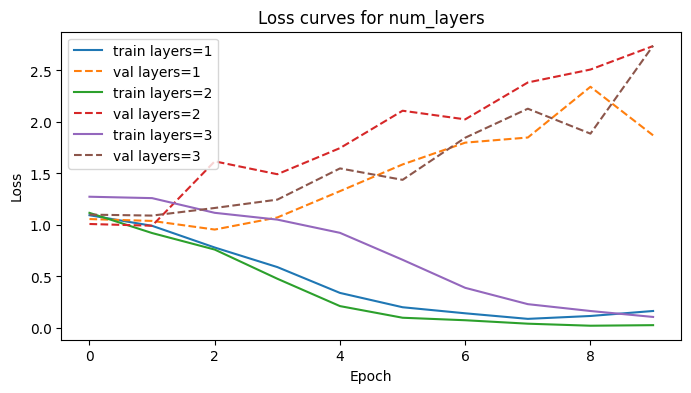

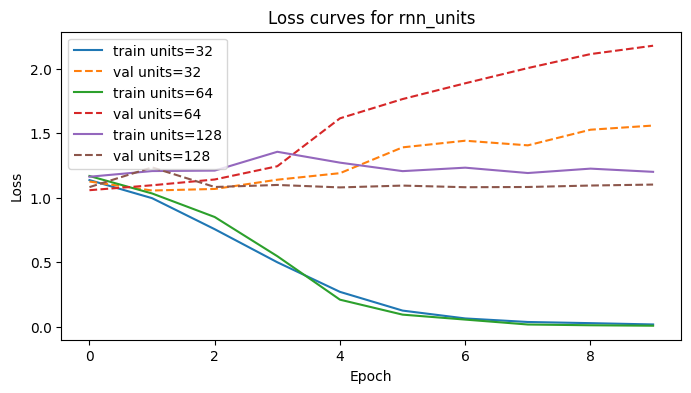

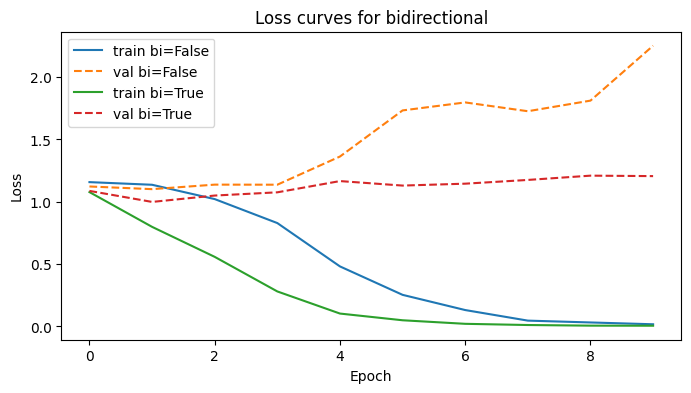

In [20]:
# Print, plot, and analyze
print_result_table(results)
plot_experiment_results(results, param_type='num_layers')
plot_experiment_results(results, param_type='rnn_units')
plot_experiment_results(results, param_type='bidirectional')

In [ ]:


def print_layer_outputs(keras_model, scratch_model, x_test, idx=0):
    """
    Print and compare intermediate outputs for the first test sample.
    """
    import numpy as np
    import tensorflow as tf

    # Prepare a single input sample (batch size 1)
    if isinstance(x_test, tf.Tensor):
        x_input = x_test.numpy()[idx:idx+1]
    else:
        x_input = np.array(x_test)[idx:idx+1]

    print(f"==== INPUT INDICES ====\n{x_input}\n")

    # 1. Keras Outputs (per layer)
    keras_outputs = []
    current = x_input
    print("==== KERAS FORWARD ====")
    for layer in keras_model.layers:
        current = layer(current)
        keras_outputs.append(current.numpy() if hasattr(current, 'numpy') else current)
        print(f"{layer.name}: shape={current.shape}")
        print(current[0] if len(current.shape) > 1 else current)
        print()

    # 2. Scratch Outputs (per layer)
    print("==== SCRATCH FORWARD ====")
    current = x_input
    outputs = []
    # Embedding
    current = scratch_model.embedding.forward(current)
    outputs.append(current)
    print(f"embedding: shape={current.shape}")
    print(current[0])
    print()
    # RNN(s) and Dropout(s), in order
    for i, layer in enumerate(scratch_model.ordered_layers):
        current = layer.forward(current)
        outputs.append(current)
        layer_type = type(layer).__name__
        print(f"{layer_type}: shape={current.shape}")
        print(current[0] if len(current.shape) > 1 else current)
        print()
    # Dense
    current = scratch_model.dense.forward(current)
    outputs.append(current)
    print(f"dense: shape={current.shape}")
    print(current[0])
    print()
    # Softmax
    current = scratch_model.softmax.forward(current)
    outputs.append(current)
    print(f"softmax: shape={current.shape}")
    print(current[0])
    print()

    # Optionally: Compare differences numerically
    # print("==== NUMERICAL DIFFERENCES ====")
    # for i, (k, s) in enumerate(zip(keras_outputs, outputs)):
    #     if isinstance(k, tf.Tensor):
    #         k = k.numpy()
    #     diff = np.abs(k - s).mean()
    #     print(f"Layer {i} mean abs difference: {diff:.6f}")
keras_model = build_rnn_model(
    vocab_size=10000, seq_len=100, embed_dim=64, rnn_units=64,
    num_layers=2, dropout_rate=0.3, bidirectional=True, num_classes=3
)
keras_model(np.zeros((1, 100), dtype=np.int32))
keras_model.load_weights("nusax_rnn.weights.h5")
print_layer_outputs(keras_model, scratch_model, x_test, idx=0)  # Try idx=0,1,2...
print_layer_outputs(keras_model, scratch_model, x_test, idx=1)  # Try idx=0,1,2...
print_layer_outputs(keras_model, scratch_model, x_test, idx=2)  # Try idx=0,1,2...